In [1]:
# Import Dependencies 
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import Dependencies 
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

# Correct path to your SQLite database
database_path = "../Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")


In [4]:
# Create the base class
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)


In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


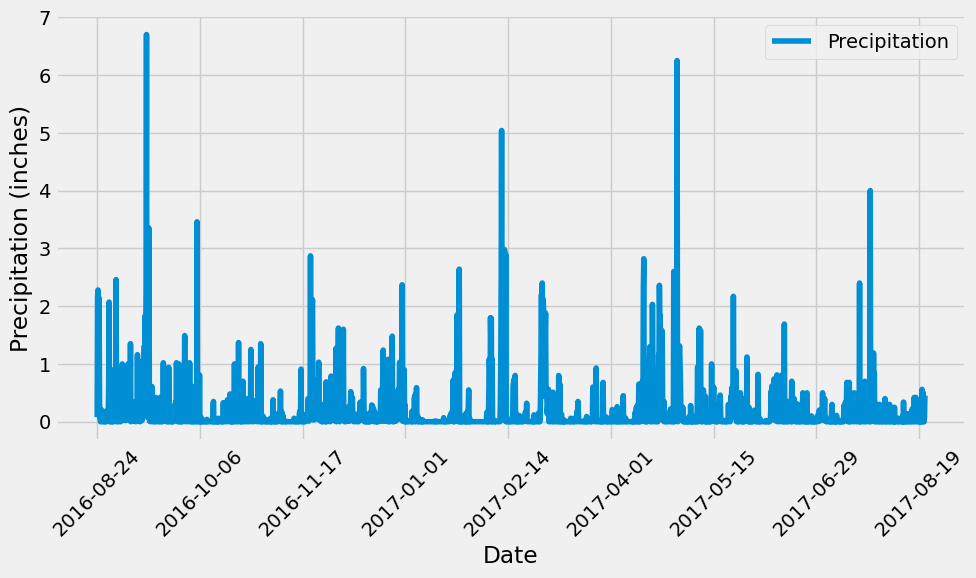

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database. 
precipitation_data = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Calculate the date one year from the last date in data set.
last_year = dt.datetime.strptime(precipitation_data, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(rain_data, columns=["Date", "Precipitation"])
precipitation_df = precipitation_df.dropna()

# Sort the dataframe by date
precipitation_df.set_index("Date", inplace=True)
precipitation_df = precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number of stations in the dataset
locations = session.query(Station)
print("There are {} stations.".format(locations.count()))

There are 9 stations.


In [12]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station).label("count")).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations_df = pd.DataFrame(active_stations, columns=["station", "count"])

most_active_station_name = ""
most_active_station = active_stations[0][0]
# List the stations and their counts in descending order.
for location in locations:
    if(location.station == active_stations[0][0]):
        most_active_station_name = location.name 
print(f"The most active stations information: ")
print(f" Name    : {most_active_station_name} ")
print(f" Station : {active_stations[0][0]}")
print(f" Count   : {active_stations[0][1]}")
print("")
print("List of the stations and the counts in descending order:")
print("Station        Counts")
print("-----------------------")
for active_station in active_stations:
    print(active_station[0], "   ", active_station[1])

The most active stations information: 
 Name    : WAIHEE 837.5, HI US 
 Station : USC00519281
 Count   : 2772

List of the stations and the counts in descending order:
Station        Counts
-----------------------
USC00519281     2772
USC00519397     2724
USC00513117     2709
USC00519523     2669
USC00516128     2612
USC00514830     2202
USC00511918     1979
USC00517948     1372
USC00518838     511


In [13]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temperature_frequencies = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
print(f"The lowest, highest and average temperature for the most active station {most_active_station} is :")
print(f" Lowest Temp  : {temperature_frequencies[0][0]}")
print(f" Highest Temp : {temperature_frequencies[0][1]}")
print(f" Average Temp : {temperature_frequencies[0][2]}")

The lowest, highest and average temperature for the most active station USC00519281 is :
 Lowest Temp  : 54.0
 Highest Temp : 85.0
 Average Temp : 71.66378066378067


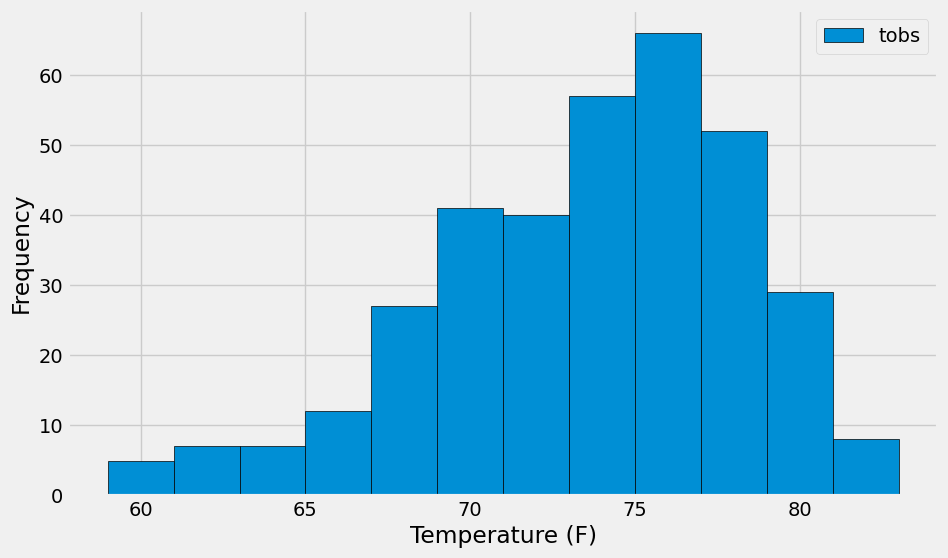

In [14]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= last_year).order_by(Measurement.date).all()

temperature_df = pd.DataFrame(temperature_data, columns=["date", "tobs"])

plt.figure(figsize=(10, 6))
plt.hist(temperature_df["tobs"], bins=12, edgecolor="black", label="tobs")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close Session

In [15]:
# Close Session
session.close()